### probabalistic forecasting of next month returns using mcmc 

In [1]:
## loading libraries

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.optimize import minimize
import seaborn as sns
import yfinance as yf


In [2]:
## tickers I want to use

tickers = ["DCOR", "VFC", "PEBK", "NZUS", "DB", "OPFI", "FNDF", "VFMV", "ROG", "VIOO"]


In [3]:
## monthly prices

def get_monthly_prices(ticker_list, start="2010-01-01", end="2025-07-01"):
    print(f"Getting data for: {ticker_list}")
    data = yf.download(ticker_list, start=start, end=end, interval="1mo", auto_adjust=True)
    
    if isinstance(data.columns, pd.MultiIndex):
        prices = data.xs("Close", level=0, axis=1)
    else:
        prices = data["Close"].to_frame()  
    
    return prices


prices_df = get_monthly_prices(tickers)

## this gets a time series of the adjusted prices
## adjusted prices account for dividends & stock splits


Getting data for: ['DCOR', 'VFC', 'PEBK', 'NZUS', 'DB', 'OPFI', 'FNDF', 'VFMV', 'ROG', 'VIOO']


[*********************100%***********************]  10 of 10 completed


In [4]:
### monthly returns

## % change calculation
returns_df = prices_df.pct_change().dropna(how="all")

## drop na
returns_df = returns_df.dropna()


In [8]:
## Finding priors using s&p 500 historical

sp500 = yf.download("^GSPC", start="1990-01-01", end="2025-01-01", interval="1mo", auto_adjust=True)

# monthly returns
sp500["Return"] = sp500["Close"].pct_change().dropna()

mean_return = sp500["Return"].mean()
std_return = sp500["Return"].std()

print(f"Mean monthly return (1990–2025): {mean_return:.4f}")
print(f"Std monthly return (1990–2025): {std_return:.4f}")


[*********************100%***********************]  1 of 1 completed

Mean monthly return (1990–2025): 0.0078
Std monthly return (1990–2025): 0.0427


In [9]:
def fit_bayesian_return_model(
    ticker_returns,
    ticker_name="",
    prior_mu=0.0078,  # mean return (calculated above)
    prior_sigma_mean=0.02,  # uncertainty around mean return
    prior_sigma_vol=0.0427, # monthly volatility
    draws=2000,
    tune=1000,
    chains=2, ## for speed reasons, can bump to 4 if desired
    cores=1,
    target_accept=0.95,
    random_seed=42,
    plot=True,
):

    with pm.Model() as model:
        # Priors informed by long-run S&P500 monthly returns
        expected_return = pm.Normal("expected_return", mu=prior_mu, sigma=prior_sigma_mean)
        return_volatility = pm.HalfNormal("return_volatility", sigma=prior_sigma_vol)

        # Likelihood
        pm.Normal("obs", mu=expected_return, sigma=return_volatility, observed=np.asarray(ticker_returns, dtype=float))

        # MCMC
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            target_accept=target_accept,
            random_seed=random_seed,
            return_inferencedata=True,
            progressbar=False,
        )

    er_samples = trace.posterior["expected_return"].values.flatten()
    vol_samples = trace.posterior["return_volatility"].values.flatten()

    simulated_next = np.random.normal(loc=er_samples, scale=vol_samples)
    prob_positive = float((simulated_next > 0).mean())

    diag = az.summary(trace, var_names=["expected_return", "return_volatility"], round_to=4)

    if plot:
        # Posterior for expected return with zero line
        az.plot_posterior(trace, var_names=["expected_return"], hdi_prob=0.95)
        plt.axvline(0.0, linestyle="--", linewidth=1)
        ttl = f"{ticker_name}: Posterior of Expected Monthly Return" if ticker_name else "Posterior of Expected Monthly Return"
        plt.title(ttl)
        plt.xlabel("Monthly return")
        plt.tight_layout()
        plt.show()

        # Posterior for volatility
        az.plot_posterior(trace, var_names=["return_volatility"], hdi_prob=0.95)
        plt.title(f"{ticker_name}: Posterior of Monthly Volatility" if ticker_name else "Posterior of Monthly Volatility")
        plt.xlabel("Std. dev. of monthly return")
        plt.tight_layout()
        plt.show()

        # Simulated next-month distribution
        plt.figure()
        plt.hist(simulated_next, bins=40, alpha=0.8)
        plt.axvline(0.0, linestyle="--", linewidth=1)
        plt.title(f"{ticker_name}: Simulated Next-Month Return\nP(>0) = {prob_positive:.2%}" if ticker_name else f"Simulated Next-Month Return\nP(>0) = {prob_positive:.2%}")
        plt.xlabel("Next-month return")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    return {
        "trace": trace,
        "prob_positive_return": prob_positive,
        "posterior_mean_return": float(er_samples.mean()),
        "posterior_mean_volatility": float(vol_samples.mean()),
        "diagnostics": diag,
        "simulated_next": simulated_next,  
    }


Initializing NUTS using jitter+adapt_diag...



=== DB ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


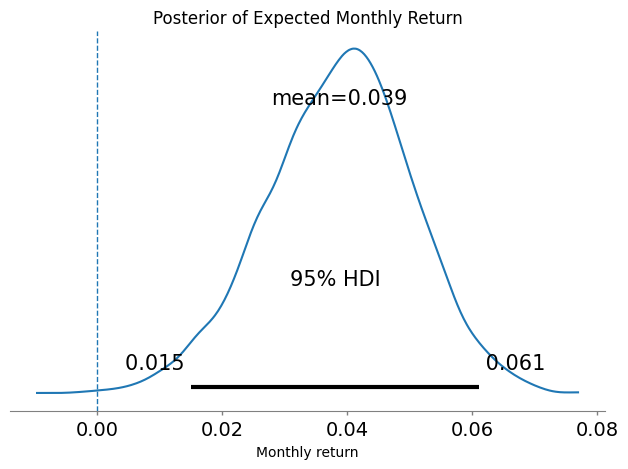

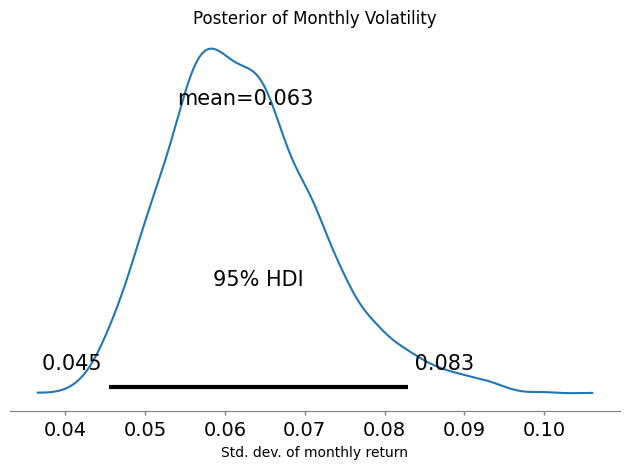

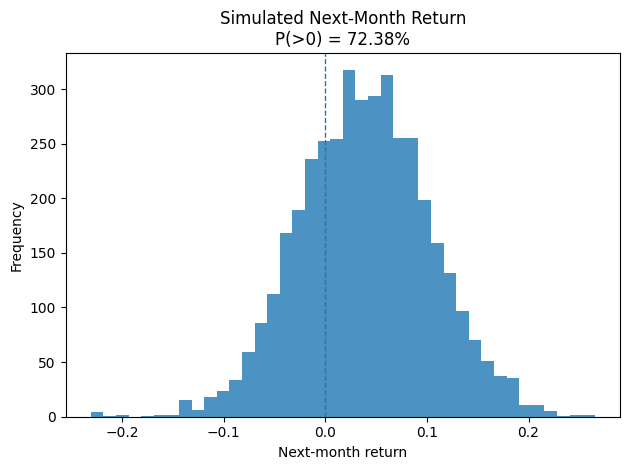

Initializing NUTS using jitter+adapt_diag...



=== DCOR ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


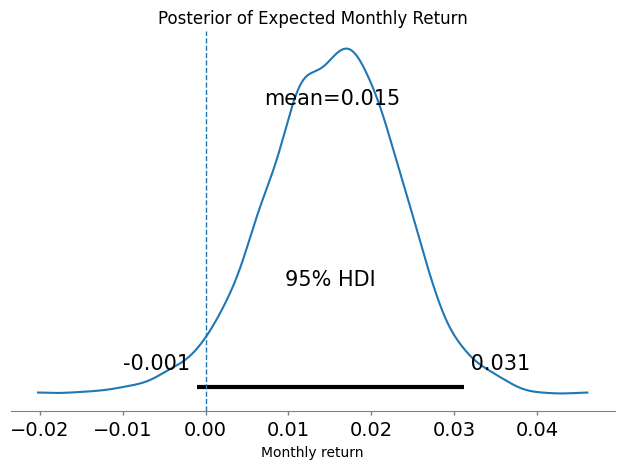

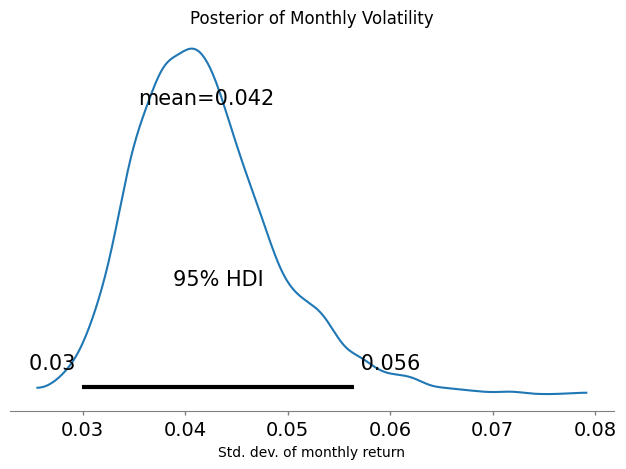

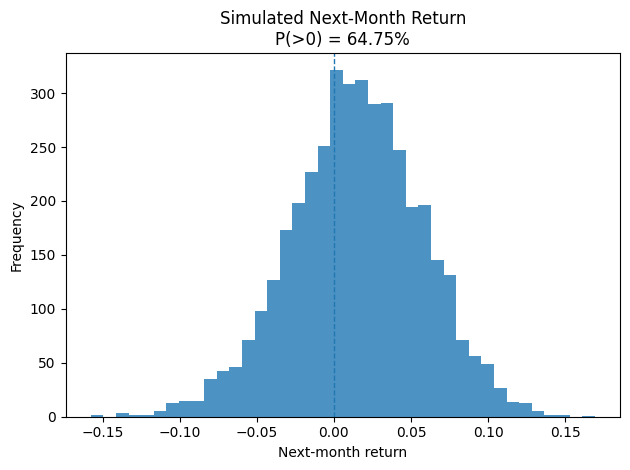

Initializing NUTS using jitter+adapt_diag...



=== FNDF ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


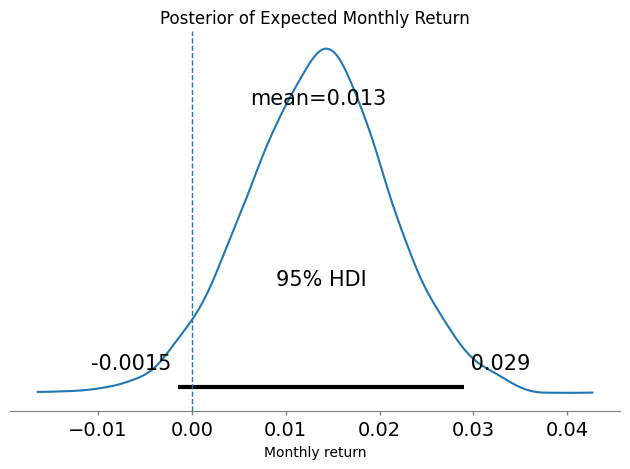

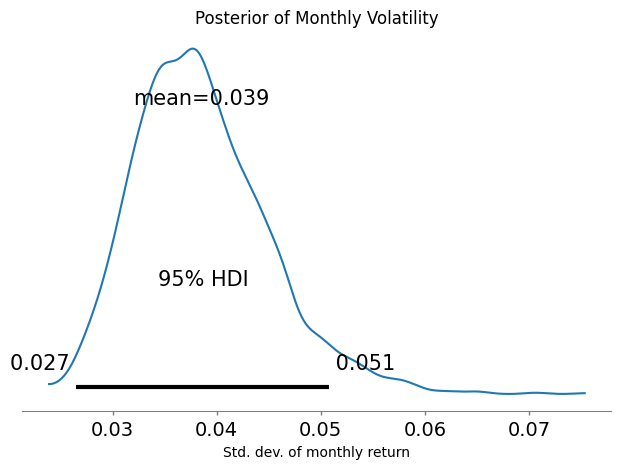

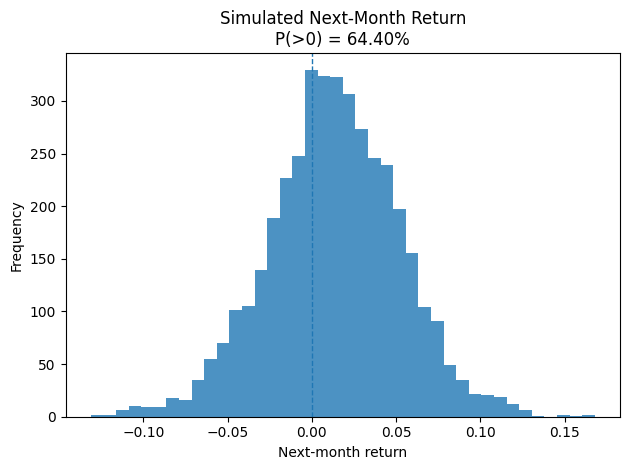

Initializing NUTS using jitter+adapt_diag...



=== NZUS ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


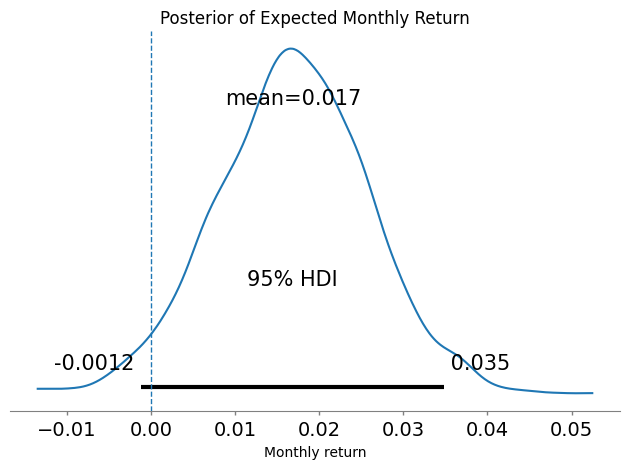

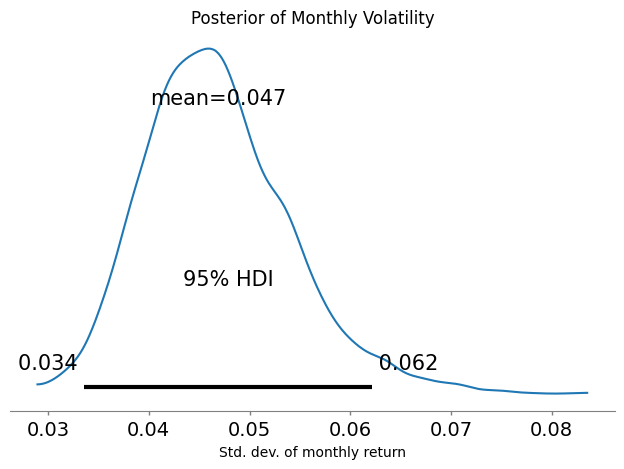

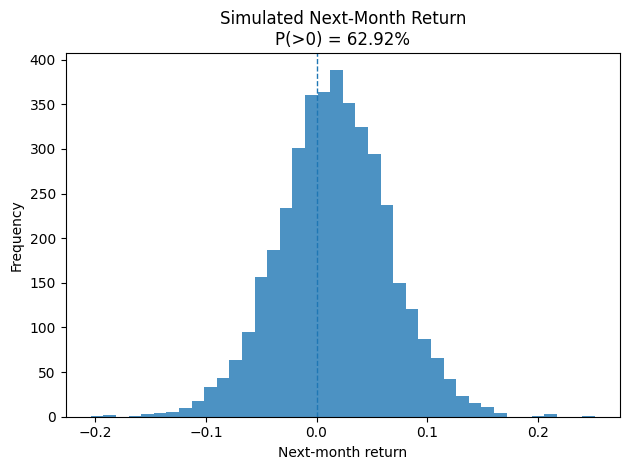

Initializing NUTS using jitter+adapt_diag...



=== OPFI ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


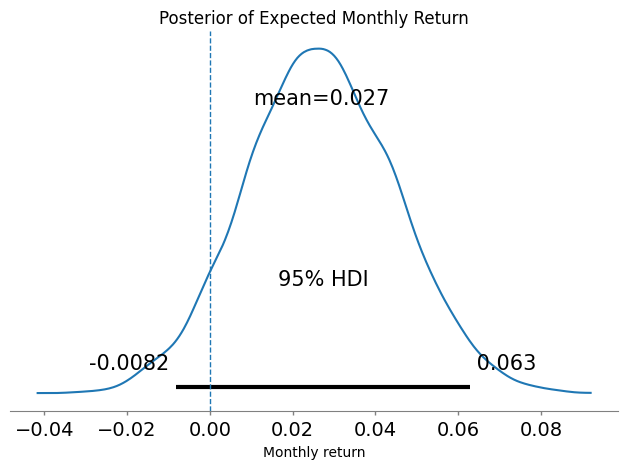

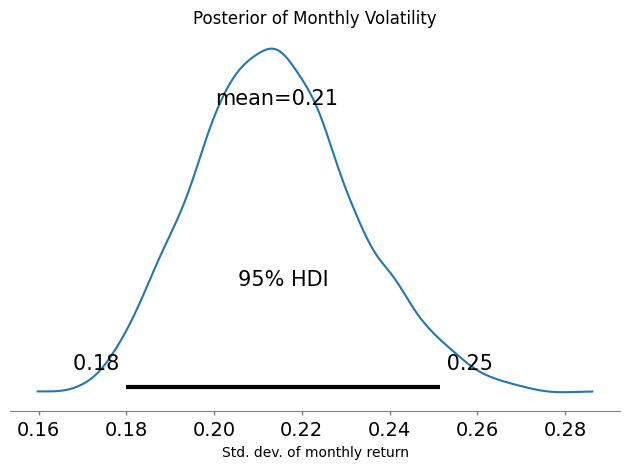

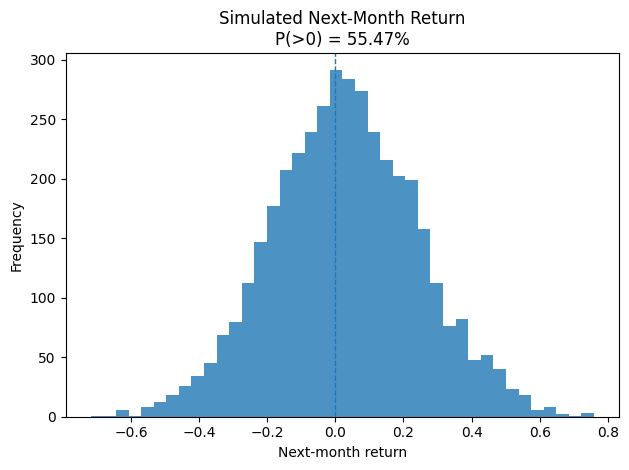

Initializing NUTS using jitter+adapt_diag...



=== PEBK ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


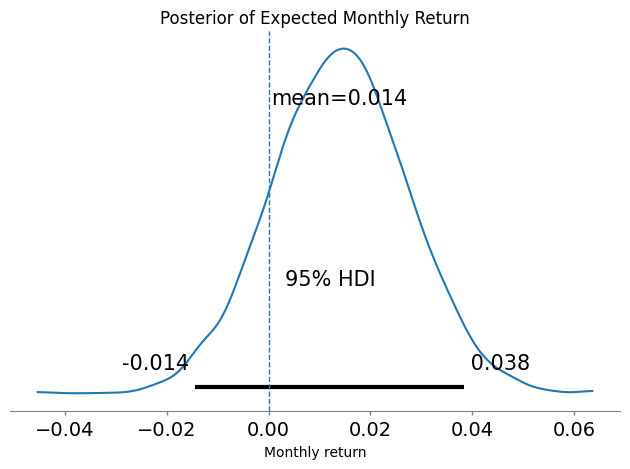

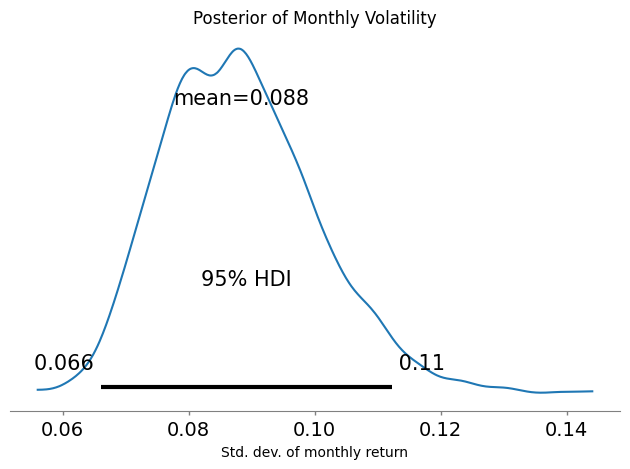

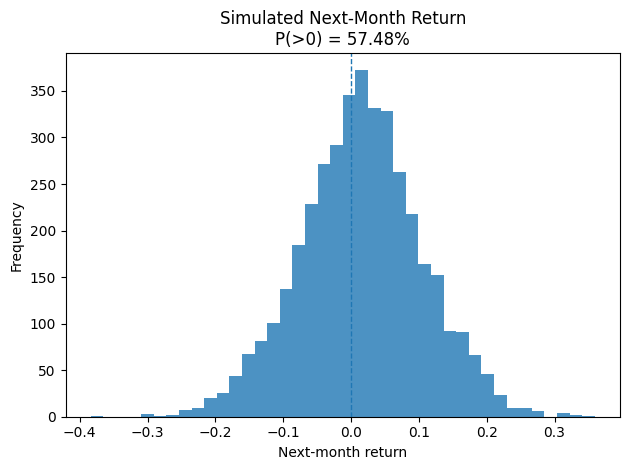

Initializing NUTS using jitter+adapt_diag...



=== ROG ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


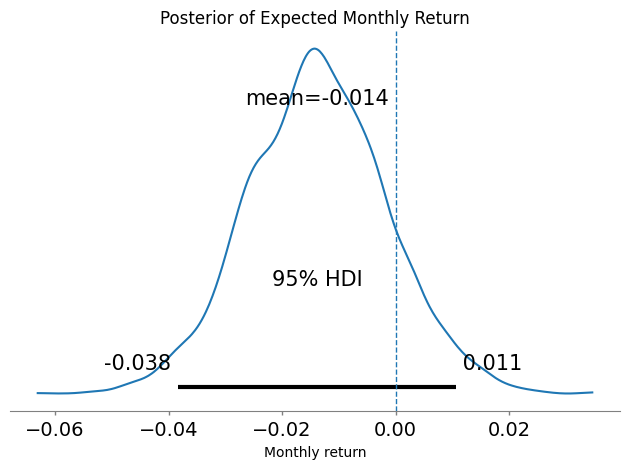

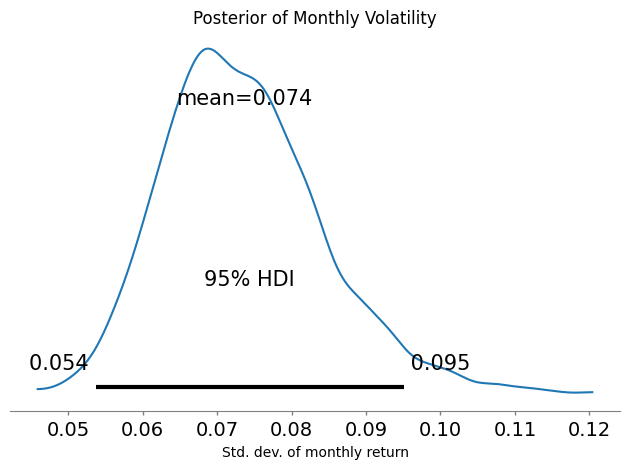

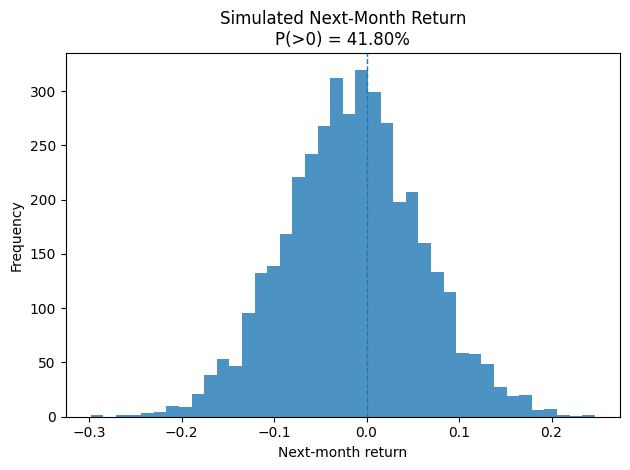

Initializing NUTS using jitter+adapt_diag...



=== VFC ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


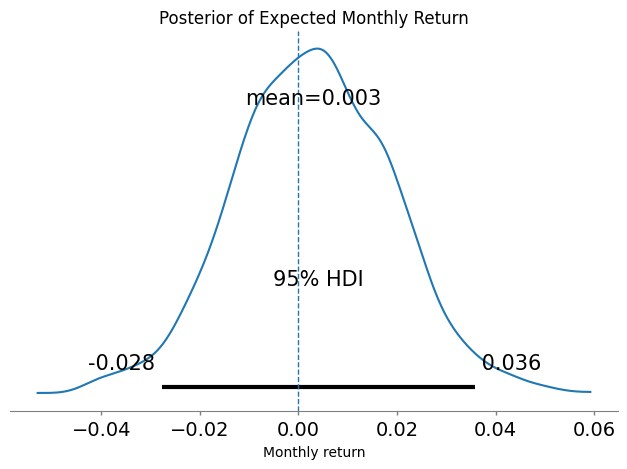

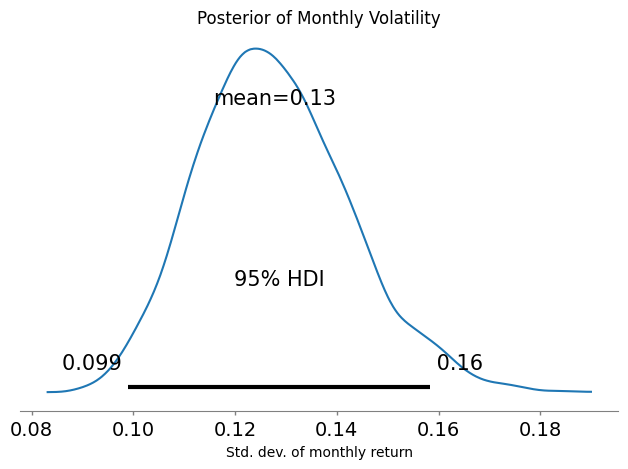

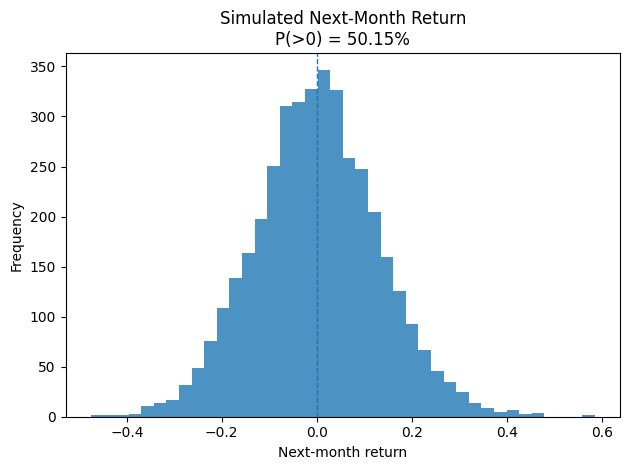

Initializing NUTS using jitter+adapt_diag...



=== VFMV ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


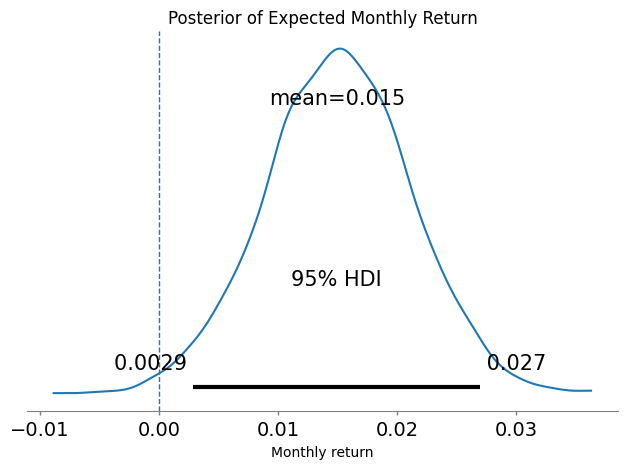

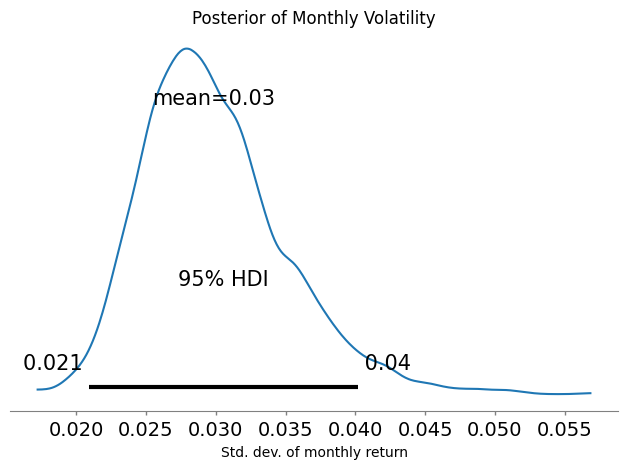

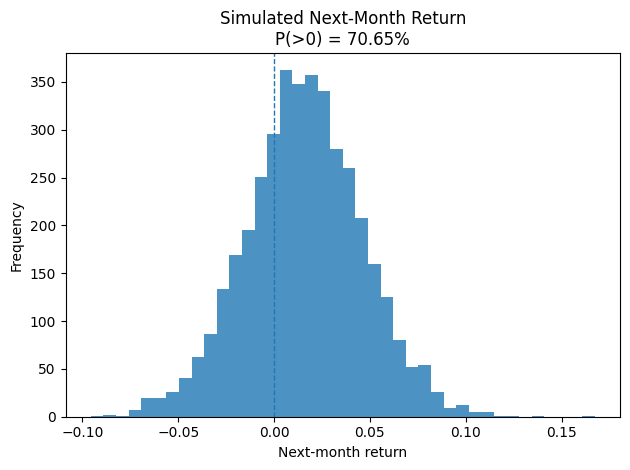

Initializing NUTS using jitter+adapt_diag...



=== VIOO ===


Sequential sampling (2 chains in 1 job)
NUTS: [expected_return, return_volatility]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


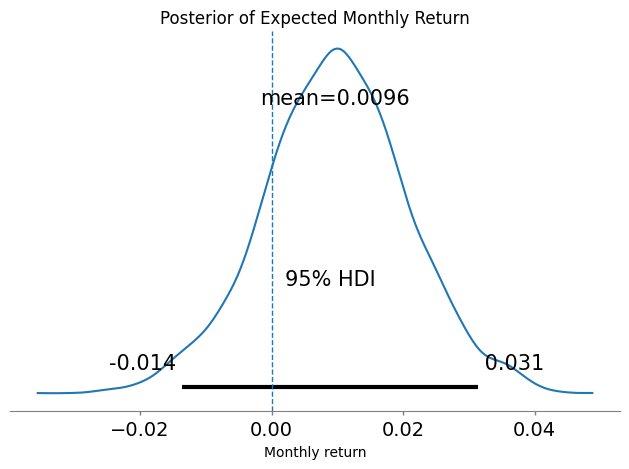

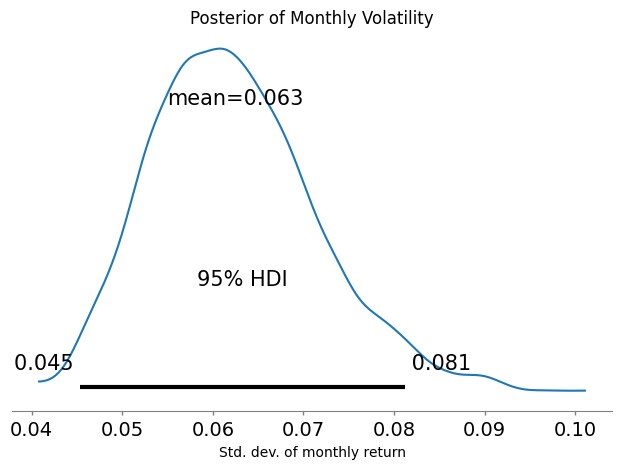

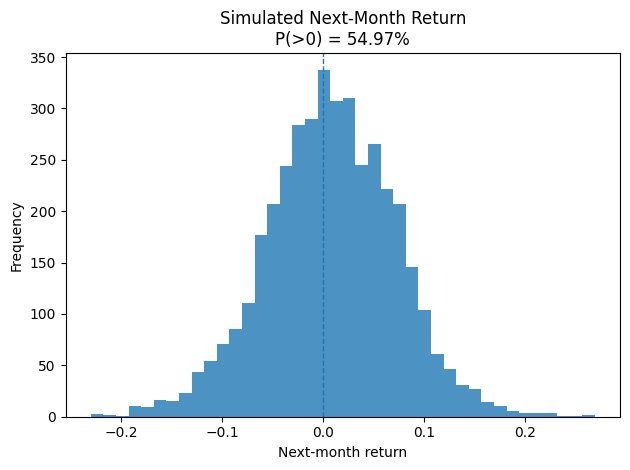

In [10]:
results = {} 

for ticker in returns_df.columns:
    print(f"\n=== {ticker} ===")
    returns = returns_df[ticker].dropna().values
    output = fit_bayesian_return_model(returns)
    results[ticker] = output


In [13]:
summary_rows = []

for ticker, res in results.items():
    ticker_returns = returns_df[ticker].dropna().values

## mcmc results
    post_mean = res["posterior_mean_return"]
    post_vol  = res["posterior_mean_volatility"]
    prob_pos  = res["prob_positive_return"]

## historical mean
    baseline_mean = np.mean(ticker_returns)
    baseline_prob_pos = np.mean(ticker_returns > 0)

### 12 month mean
    if len(ticker_returns) >= 12:
        rolling_mean = pd.Series(ticker_returns).rolling(window=12).mean().iloc[-1]
    else:
        rolling_mean = np.nan

    summary_rows.append({
        "ticker": ticker,
        "bayes_mean": post_mean,
        "bayes_vol": post_vol,
        "bayes_prob_pos": prob_pos,
        "baseline_mean": baseline_mean,
        "baseline_prob_pos": baseline_prob_pos,
        "rolling12_mean": rolling_mean
    })

summary_df = pd.DataFrame(summary_rows)

display(summary_df.round(4))

summary_df.to_csv("~/Desktop/stock_summary.csv", index=False)


,ticker,bayes_mean,bayes_vol,bayes_prob_pos,baseline_mean,baseline_prob_pos,rolling12_mean
0,DB,0.0387,0.0625,0.7238,0.0523,0.8095,0.0557
1,DCOR,0.0152,0.0420,0.6475,0.0173,0.6667,0.0114
2,FNDF,0.0134,0.0385,0.6440,0.0148,0.7143,0.0151
3,NZUS,0.0169,0.0469,0.6292,0.0190,0.6667,0.0117
4,OPFI,0.0268,0.2143,0.5548,0.1272,0.6667,0.1617
5,PEBK,0.0140,0.0883,0.5748,0.0199,0.5714,0.0059
6,ROG,-0.0138,0.0736,0.4180,-0.0278,0.4762,-0.0428
7,VFC,0.0030,0.1278,0.5015,-0.0052,0.5238,0.0061
8,VFMV,0.0150,0.0299,0.7065,0.0156,0.7143,0.0119
9,VIOO,0.0096,0.0625,0.5498,0.0103,0.5238,0.0058


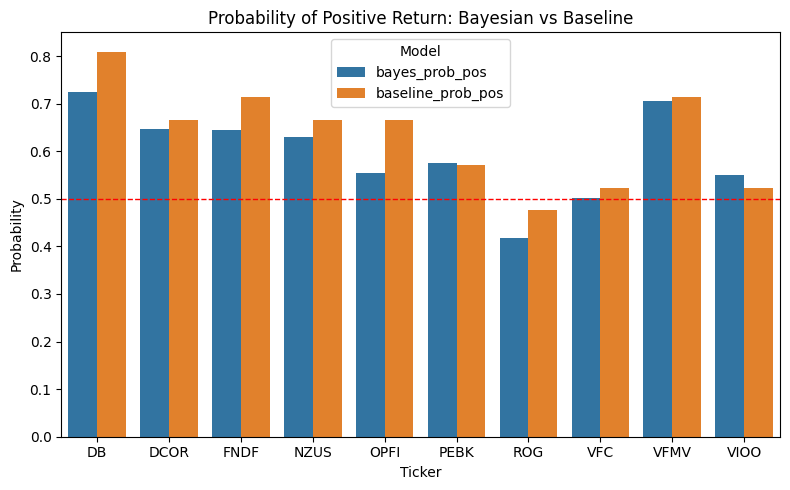

In [14]:
plt.figure(figsize=(8,5))
plot_df = summary_df.melt(id_vars="ticker", 
                          value_vars=["bayes_prob_pos", "baseline_prob_pos"], 
                          var_name="model", value_name="prob_pos")

sns.barplot(data=plot_df, x="ticker", y="prob_pos", hue="model")
plt.axhline(0.5, color="red", linestyle="--", linewidth=1)  # breakeven line
plt.title("Probability of Positive Return: Bayesian vs Baseline")
plt.ylabel("Probability")
plt.xlabel("Ticker")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
